# [IAPR 2019:][iapr2019] Lab 2 ‒  Object description

**Author:** Yue Xu  
**Partner:** Tianlun Luo      
**Due date:** 19.04.2019

[iapr2019]: https://github.com/LTS5/iapr-2019

## Extract relevant data
We first need to extract the `lab-02-data.tar.gz` archive.
To this end, we use the [tarfile] module from the Python standard library.

[tarfile]: https://docs.python.org/3.6/library/tarfile.html

In [1]:
import tarfile
import os

import numpy as np
import matplotlib.pyplot as plt
import cv2 

data_base_path = os.path.join(os.pardir, 'data')
data_folder = 'lab-02-data'
tar_path = os.path.join(data_base_path, data_folder + '.tar.gz')
with tarfile.open(tar_path, mode='r:gz') as tar:
    tar.extractall(path=data_base_path)

## Description
In the `lab-02-data/` folder, you will find 28x28 grey-scale pictures of handwritten "0" and "1".
These digits have been extracted from MNIST dataset (http://yann.lecun.com/exdb/mnist/).

Your goal is to extract, from each of those images, a 2-dimensional feature vector (i.e. 2 features) and to plot them all on a 2D graph.
If you have chosen good features, the vectors of the "0"'s should nicely cluster in one part of the plane and those of the "1"'s in another.

Please try first the Fourier Descriptors.
You can make several attempts: e.g. with and without invariance to rotation, translation, scaling, etc.
You can also for instance rotate the images and assess the invariance in rotation.

**Note:** for the Fourier descriptors, the u_k signal has to be constructed by following the contour point after point.
Some pre-processing (image binarization, possibly some Mathematical Morphology) might be useful.

Then feel free to try other features, the more you try, the better it will be (for you).

### 1.1 Data visualization

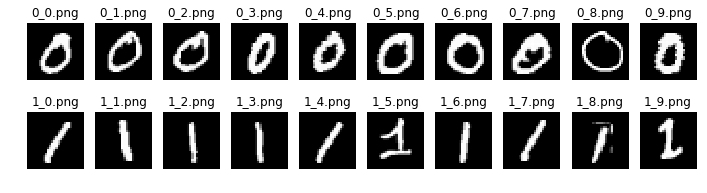

In [2]:
import skimage.io
import matplotlib.pyplot as plt
%matplotlib inline

# Load images
data_base_path = os.path.join(os.pardir, 'data')
data_folder = 'lab-02-data'
#  Load zeros
zeros_path = os.path.join(data_base_path, data_folder, '0')
zeros_names = [nm for nm in os.listdir(zeros_path) if '.png' in nm]  # make sure to only load .png
zeros_names.sort()  # sort file names
ic = skimage.io.imread_collection([os.path.join(zeros_path, nm) for nm in zeros_names])
zeros_im = skimage.io.concatenate_images(ic)
#  Load ones
ones_path = os.path.join(data_base_path, data_folder, '1')
ones_names = [nm for nm in os.listdir(ones_path) if '.png' in nm]  # make sure to only load .png
ones_names.sort()  # sort file names
ic = skimage.io.imread_collection(([os.path.join(ones_path, nm) for nm in ones_names]))
ones_im = skimage.io.concatenate_images(ic)

# Plot images
fig, axes = plt.subplots(2, len(zeros_im), figsize=(12, 3))
for ax, im, nm in zip(axes[0], zeros_im, zeros_names):
    ax.imshow(im, cmap='gray')
    ax.axis('off')
    ax.set_title(nm)
for ax, im, nm in zip(axes[1], ones_im, ones_names):
    ax.imshow(im, cmap='gray')
    ax.axis('off')
    ax.set_title(nm)

### 1.2 Fourier descriptors

#### Implementation: 

Fourier descriptors is a way to describe shape of an object. In order to find the fourier descriptor, we first need to take the discrete fourier transform of the boundary or contour of the object in the image. This means that every point in the contour maps to a complex number. Our implementation of finding the fourier descriptors is in the function findDescriptor() below, where the input is an image and the output are the fourier descriptors. In the function, we first find the contours of an image, the sort the contours by largest area, then, perform DFT on the contour values. 

We used this function to compare and contrast different feature extraction given the fourier descriptors. We will looks at features that are translational invariant, translational + rotational invariance, and translational + rotational + scaling invariant. The results for each method is shown in the scatter plot, where the blue dots represents features of zeros_im and the green dots represents features of ones_im.

#### Discussion:

Method 1: We first implemented the baseline, where the first feature represents the 0th fourier component and the second feature represents the 1st fourier component. We found that taking just the imaginary component of the fourier component gave the best clusters. This is the baseline method because it does not have any translational, rotational, or scaling invariance. The image was not preprocessed. We found that this method allows the feature space to be linearly seperatable. 

Method 2: We then preprocessed the images and applied the baseline method described above to the preprocessed images. Specifically, we apply a Gaussian blur to the image then thresholded the image. We think that applying a Gaussian blur would smooth out sharp edges in the object's contour and make the shape of the object for images belonging to same class more similar to each other. With preprocessing, we observe from the plot that the features for the zero images are more compactly clustered compare to the plot from method without preprocessing. However, preprocessing didn't help with the one images since the shapes of the contours are still very distinct from each other after the Gaussian blur. Overall, the feature space produced by this method is not linearly separable. 

Method 3: We then made the Fourier descriptors to be invariant to translations. Since the translations of a signal only affects the zeroth term in its Fourier transform(f0), therefore, to be invariant to translations, we ignore f0, and use the first and second terms(f1 and f2) as the two features for each image. We have proven below that this method is invariant to translations by computing f1 and f2 for an image and an translated version of that image, and we found that f1 and f2 are exactly the same for both images. Overall, we observe from the our plot that features for the two classes do form clusters, but the inter-class variance is not large enough for the feature space to be linearly separable.

Method 4: We now made the Fourier descriptors invariant to translations and rotations. This is achieved by taking the magnitude of the 1st and 2nd fourier descriptors as our two features. Proof of rotational invariance by taking the magnitude is proveded in the section below. We see that the feature vector prodced by the original image is the same as the feature vector produced by the same image rotated clockwise by 90 degrees. This makes intuitive sense since the magnitude of a complex number does not have information of the phase. The result is linearly sepretable when we apply preprocessing to the input image. 

Method 5: We now made the Fourier descriptors invariant to translation, rotations, and scaling. This is achieved by taking the absolution values of the 1st and 2nd Fourier components and dividing it by the magnitude of the 1st component. This makes intuitive sense saling is simply multiplying x(k) and y(k) of the contours by some constant. By finding the ratio, we eliminate that scaling factor. Proof of scaling invariance by taking the ratio is shown below, where we see the feature vector prodced by the original image is similar as the feature vector produced by the same image scaled down by 50 percent. However, this method produces results that are not well clustered and is not linearly sepretable, even with preprocessing. 


In [3]:
def findDescriptor(img):
    #finds contour
    im2, contour, hierarchy = cv2.findContours(img, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    #sort contours by area
    contour = sorted(contour, key=cv2.contourArea, reverse=True) 
    #finds contour with largest area
    contour_array = contour[0][:, 0, :]
    contour_complex = np.empty(contour_array.shape[:-1], dtype=complex)
    contour_complex.real = contour_array[:, 0]
    contour_complex.imag = contour_array[:, 1]
    #perform discrete fourier transform
    fourier_result = np.fft.fft(contour_complex)
    return fourier_result

### Method 1: Baseline

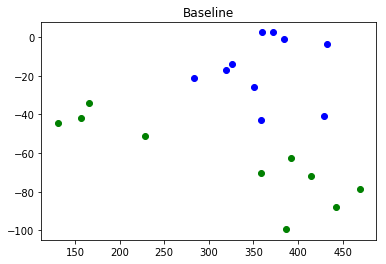

In [4]:
#baseline, no preprocessing, or normalization of fourier descriptors
#no translational, rotation, or scaling invariance

zero_x = np.zeros(10)
zero_y = np.zeros(10)
one_x = np.zeros(10)
one_y = np.zeros(10)

for i in range(len(zeros_im)):
    im = findDescriptor(zeros_im[i])
    zero_x[i] = im[0].imag 
    zero_y[i] = im[1].imag 


for i in range(len(ones_im)):
    im = findDescriptor(ones_im[i])
    one_x[i] = im[0].imag 
    one_y[i] = im[1].imag 
    
plt.scatter(zero_x, zero_y, color = 'b')
plt.scatter(one_x, one_y, color = 'g')
plt.title('Baseline')
plt.show()


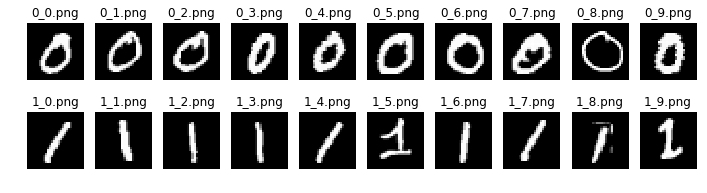

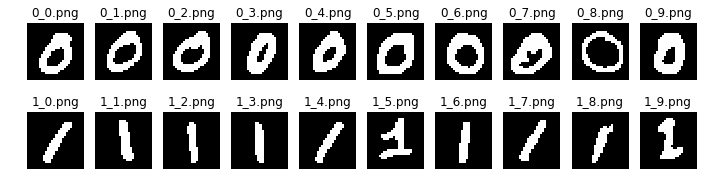

In [5]:
fig, axes = plt.subplots(2, len(zeros_im), figsize=(12, 3))
for ax, im, nm in zip(axes[0], zeros_im, zeros_names):
    ax.imshow(im, cmap='gray')
    ax.axis('off')
    ax.set_title(nm)
for ax, im, nm in zip(axes[1], ones_im, ones_names):
    ax.imshow(im, cmap='gray')
    ax.axis('off')
    ax.set_title(nm)
# Plot images
fig, axes = plt.subplots(2, len(zeros_im), figsize=(12, 3))
for ax, im, nm in zip(axes[0], zeros_im, zeros_names):
    im = cv2.GaussianBlur(im,(3,3),1)
    flag, im = cv2.threshold(im, 70, 255, cv2.THRESH_BINARY)
    #im = cv2.morphologyEx(im, cv2.MORPH_CLOSE, kernel)
    ax.imshow(im, cmap='gray')
    ax.axis('off')
    ax.set_title(nm)
for ax, im, nm in zip(axes[1], ones_im, ones_names):
    im = cv2.GaussianBlur(im,(3,3),1)
    flag, im = cv2.threshold(im, 70, 255, cv2.THRESH_BINARY)
    #im = cv2.morphologyEx(im, cv2.MORPH_CLOSE, kernel)
    ax.imshow(im, cmap='gray')
    ax.axis('off')
    ax.set_title(nm)

### Method 2: Baseline + Preprocessing

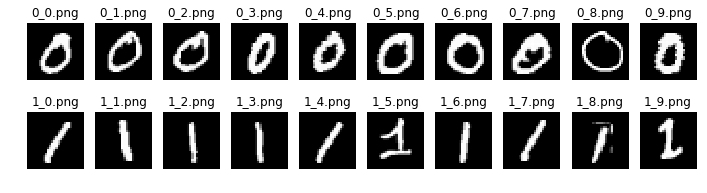

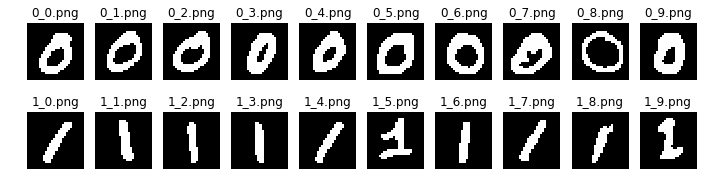

In [6]:
#Preprocessing visualization

fig, axes = plt.subplots(2, len(zeros_im), figsize=(12, 3))
for ax, im, nm in zip(axes[0], zeros_im, zeros_names):
    ax.imshow(im, cmap='gray')
    ax.axis('off')
    ax.set_title(nm)
for ax, im, nm in zip(axes[1], ones_im, ones_names):
    ax.imshow(im, cmap='gray')
    ax.axis('off')
    ax.set_title(nm)
# Plot images
fig, axes = plt.subplots(2, len(zeros_im), figsize=(12, 3))
for ax, im, nm in zip(axes[0], zeros_im, zeros_names):
    im = cv2.GaussianBlur(im,(3,3),1)
    flag, im = cv2.threshold(im, 70, 255, cv2.THRESH_BINARY)
    #im = cv2.morphologyEx(im, cv2.MORPH_CLOSE, kernel)
    ax.imshow(im, cmap='gray')
    ax.axis('off')
    ax.set_title(nm)
for ax, im, nm in zip(axes[1], ones_im, ones_names):
    im = cv2.GaussianBlur(im,(3,3),1)
    flag, im = cv2.threshold(im, 70, 255, cv2.THRESH_BINARY)
    #im = cv2.morphologyEx(im, cv2.MORPH_CLOSE, kernel)
    ax.imshow(im, cmap='gray')
    ax.axis('off')
    ax.set_title(nm)

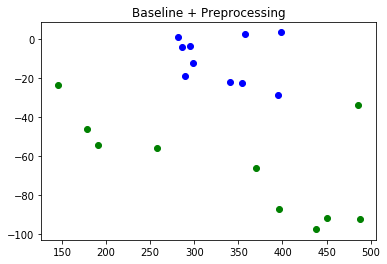

In [212]:
#With preproceessing of image
#First with Gaussian Blur
#Then with Thresholding

zero_x = np.zeros(10)
zero_y = np.zeros(10)
one_x = np.zeros(10)
one_y = np.zeros(10)

for i in range(len(zeros_im)):
    im = zeros_im[i]
    im = cv2.GaussianBlur(im,(3,3),1)
    flag, im = cv2.threshold(im, 70, 255, cv2.THRESH_BINARY)
    im = findDescriptor(im)
    zero_x[i] = im[0].imag 
    zero_y[i] = im[1].imag 


for i in range(len(ones_im)):
    im = ones_im[i]
    im = cv2.GaussianBlur(im,(3,3),1)
    flag, im = cv2.threshold(im, 70, 255, cv2.THRESH_BINARY)
    im = findDescriptor(im)
    one_x[i] = im[0].imag 
    one_y[i] = im[1].imag 
    
plt.scatter(zero_x, zero_y, color = 'b')
plt.scatter(one_x, one_y, color = 'g')
plt.title('Baseline + Preprocessing')
plt.show()

### Method 3: Translational Invariance

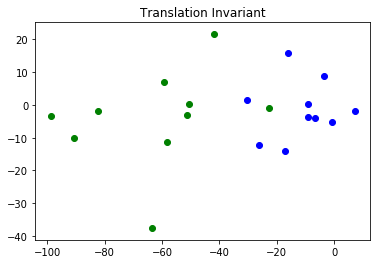

In [7]:
#translational invariance

zero_x = np.zeros(10)
zero_y = np.zeros(10)
one_x = np.zeros(10)
one_y = np.zeros(10)

for i in range(len(zeros_im)):
    im = zeros_im[i]
    im = cv2.GaussianBlur(im,(9,9),1)
    flag, im = cv2.threshold(im, 80, 255, cv2.THRESH_BINARY)
    test = findDescriptor(im)
    zero_x[i] = test[1].imag
    zero_y[i] = test[2].imag

for i in range(len(ones_im)):
    im = ones_im[i]
    im = cv2.GaussianBlur(im,(9,9),1)
    flag, im = cv2.threshold(im, 80, 255, cv2.THRESH_BINARY)
    test = findDescriptor(im)
    one_x[i] = test[1].imag
    one_y[i] = test[2].imag
    
plt.scatter(zero_x, zero_y, color = 'b')
plt.scatter(one_x, one_y, color = 'g')
plt.title('Translation Invariant')
plt.show()

### Method 4: Translational + Rotational Invariance

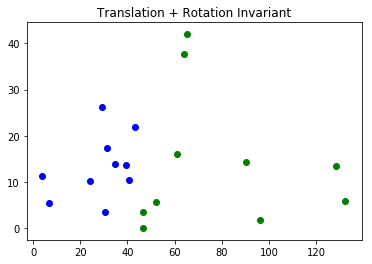

In [8]:
#rotational invariance

zero_x = np.zeros(10)
zero_y = np.zeros(10)
one_x = np.zeros(10)
one_y = np.zeros(10)

for i in range(len(zeros_im)):
    im = zeros_im[i]
    im = cv2.GaussianBlur(im,(5,5), 1)
    flag, im = cv2.threshold(im, 80, 255, cv2.THRESH_BINARY)
    test = findDescriptor(im)
    zero_x[i] = abs(test[1])
    zero_y[i] = abs(test[2])

for i in range(len(ones_im)):
    im = ones_im[i]
    im = cv2.GaussianBlur(im,(5,5), 1)
    flag, im = cv2.threshold(im, 80, 255, cv2.THRESH_BINARY)
    test = findDescriptor(im)
    one_x[i] = abs(test[1])
    one_y[i] = abs(test[2])
    
plt.scatter(zero_x, zero_y, color = 'b')
plt.scatter(one_x, one_y, color = 'g')
plt.title('Translation + Rotation Invariant')
plt.show()


### Method 5: Translational + Rotational + Scale Invariance

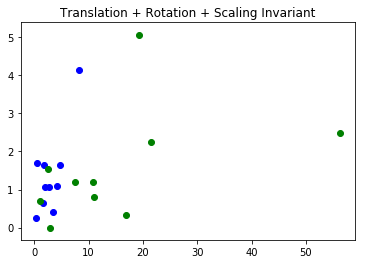

In [9]:
#rotational invariance

zero_x = np.zeros(10)
zero_y = np.zeros(10)
one_x = np.zeros(10)
one_y = np.zeros(10)

for i in range(len(zeros_im)):
    im = zeros_im[i]
    im = cv2.GaussianBlur(im,(5,5), 1)
    flag, im = cv2.threshold(im, 80, 255, cv2.THRESH_BINARY)
    test = findDescriptor(im)
    zero_x[i] = abs(test[1]/abs(test[3]))
    zero_y[i] = abs(test[2]/ abs(test[3]))

for i in range(len(ones_im)):
    im = ones_im[i]
    im = cv2.GaussianBlur(im,(5,5), 1)
    flag, im = cv2.threshold(im, 80, 255, cv2.THRESH_BINARY)
    test = findDescriptor(im)
    one_x[i] = abs(test[1]/abs(test[3]))
    one_y[i] = abs(test[2]/abs(test[3]))
    
plt.scatter(zero_x, zero_y, color = 'b')
plt.scatter(one_x, one_y, color = 'g')
plt.title('Translation + Rotation + Scaling Invariant')
plt.show()



### Testing Invariances

Below is a proof of concept to show that the fourier descriptor features we chose are in fact invarient to translation, rotation, and scale. We use the first zero image as an example, and we compare the original features with the translated/rotated/scaled features extracted and show that they are the same.

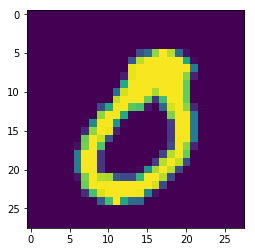

In [10]:
#Original Image
test = zeros_im[0]
plt.imshow(test)

#### Proof of Translational Invariance

Original features: 28.787306480823265 -0.053830088575940294
Translated features: 28.787306480823265 -0.053830088575940294


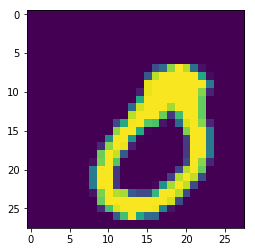

In [11]:
#Original image
fd = findDescriptor(test)
x = fd[1].real
y = fd[2].real
print("Original features:", x, y)

#Image translated by 2 in the x and y direction
M = np.float32([[1,0,2],[0,1,2]])
dst = cv2.warpAffine(test,M,(28,28))
plt.imshow(dst)
fd = findDescriptor(dst)
x = fd[1].real
y = fd[2].real
print("Translated features:", x, y)

#### Proof of Rotational Invariance

Original features: 49.84616436180811 4.4370657287931605
Rotated features: 49.84616436180807 4.43706572879317


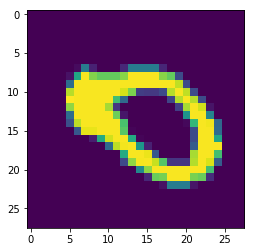

In [12]:
#Original image
fd = findDescriptor(test)
x = abs(fd[1])
y = abs(fd[2])
print("Original features:", x, y)

#Image rotated clockwise by 90 degrees
M = cv2.getRotationMatrix2D((14,14), 90, 1)
rotated = cv2.warpAffine(test, M, (28, 28))
plt.imshow(rotated)
fd = findDescriptor(rotated)
x = abs(fd[1])
y = abs(fd[2])
print("Rotated features:", x, y)

#### Proof of Scaling Invariance

Original features: 0.9999999999999999 0.08901518874324499
Scaled features: 0.9999999999999998 0.05058806901460204


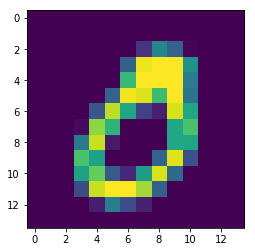

In [13]:
#Original image
fd = findDescriptor(test)
x = abs(fd[1]/abs(fd[1]))
y = abs(fd[2]/abs(fd[1]))
print("Original features:", x, y)

#Image scaled down 
small = cv2.resize(test, (0,0), fx=0.5, fy=0.5) 
plt.imshow(small)
fd = findDescriptor(small)
x = abs(fd[1]/abs(fd[1]))
y = abs(fd[2]/abs(fd[1]))
print("Scaled features:", x, y)

### 1.3 Additional method(s)

#### Discussion:

Method 1: In this method, the first feature is defined as the area of the contour and the second feature is the perimenter of the contour. The contour used is the contour with the largest area. This simple feature extraction produces very good results with clear clusters for zero_images and one_images. 

Method 2: In this method, we used the first and second component of Hu Moments as our two features. First we used cv2.moments() to get the original 24 moments, then we used cv2.HuMoments() to calculate Hu’s seven invariant moments, which are invariant to translation, scale, and rotation. Finally, we took the Log Transform of Hu's Moments in order to prevent noise and spikiness of features. The result is linearly sepretable.

Method 3: In this method, we tried out KAZE's algorithm at feature extraction. According to the paper below, Kaze features are multiscale 2D feature detection and description algorithm in nonlinear scale spaces. The idea is to create the scale space of an image by filtering the original image with an appropriate function over increasing time
or scale. So we tried this implementation since the algorithm came with opencv. The results were not very promising since individual classes are not well clustered.

Method 4: In this method, we attempted to extract features from the images using the axes of inertia method described in the lecture. Specifically, we first find the covariance matrix of the image, then we find the eigenvalues of the covariance matrix. We use the largest and the second largest eigenvalues as the two descriptors for each image. The corresponding eigenvectors of the largest and the second largest eigenvalues represent the first two principal axes of inertia, which gives us information about the shape and orientation of the object within the image. Here we are only using the eigenvalues to describe our images, not the eigenvectors. The eigenvalues gives us information about the length of their corresponding eigenvectors, and the feature space given by the eigenvalue is linearly separable as shown in the plot below.

Paper: Alcantarilla P.F., Bartoli A., Davison A.J. (2012) KAZE Features. In: Fitzgibbon A., Lazebnik S., Perona P., Sato Y., Schmid C. (eds) Computer Vision – ECCV 2012. ECCV 2012. Lecture Notes in Computer Science, vol 7577. Springer, Berlin, Heidelberg


### Method 1: Area + Perimeter

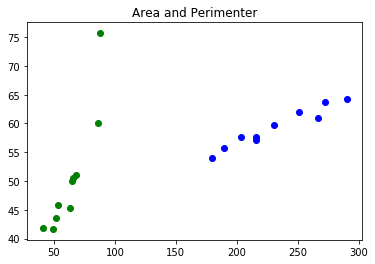

In [10]:
#features from area/perimeter of contour
zero_x = np.zeros(10)
zero_y = np.zeros(10)
one_x = np.zeros(10)
one_y = np.zeros(10)

for i in range(len(zeros_im)):
    im = zeros_im[i]
    im = cv2.GaussianBlur(im,(5,5),1)
    flag, im = cv2.threshold(im, 80, 255, cv2.THRESH_BINARY)
    im2, contour, hierarchy = cv2.findContours(im, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    contour = sorted(contour, key=cv2.contourArea, reverse=True)
    zero_x[i] = cv2.contourArea(contour[0])
    zero_y[i] = cv2.arcLength(contour[0],True)

for i in range(len(ones_im)):
    im = ones_im[i]
    im = cv2.GaussianBlur(im,(5,5),1)
    flag, im = cv2.threshold(im, 80, 255, cv2.THRESH_BINARY)
    im2, contour, hierarchy = cv2.findContours(im, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    contour = sorted(contour, key=cv2.contourArea, reverse=True)
    one_x[i] = cv2.contourArea(contour[0])
    one_y[i] = cv2.arcLength(contour[0],True)
    
plt.scatter(zero_x, zero_y, color = 'b')
plt.scatter(one_x, one_y, color = 'g')
plt.title('Area and Perimenter')
plt.show()


### Method 2: Hu Moments

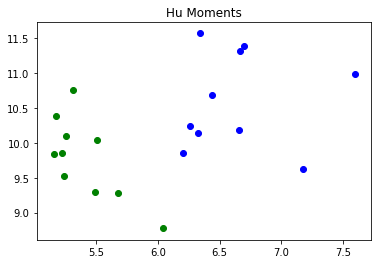

In [221]:
#Using Hu Moments, Log transformed
#Invariant to translation, scale, and rotation
#1st term is moment of inertia around the image's centroid

zero_x = np.zeros(10)
zero_y = np.zeros(10)
one_x = np.zeros(10)
one_y = np.zeros(10)

for i in range(len(zeros_im)):
    im = zeros_im[i]
    im = cv2.HuMoments(cv2.moments(im)).flatten()
    im = -np.sign(im) * np.log10(np.abs(im))
    zero_x[i] = im[1]
    zero_y[i] = im[2]

for i in range(len(ones_im)):
    im = ones_im[i]
    im = cv2.HuMoments(cv2.moments(im)).flatten()
    im = -np.sign(im) * np.log10(np.abs(im))
    one_x[i] = im[1]
    one_y[i] = im[2]

plt.scatter(zero_x, zero_y, color = 'b')
plt.scatter(one_x, one_y, color = 'g')
plt.title('Hu Moments')
plt.show()

### Method 3: KAZE

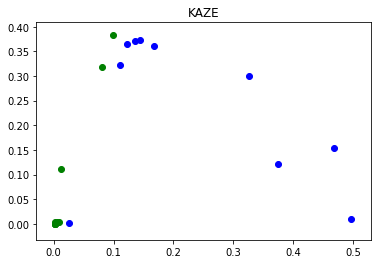

In [222]:
detector = cv2.KAZE_create()

zero_x = np.zeros(10)
zero_y = np.zeros(10)
one_x = np.zeros(10)
one_y = np.zeros(10)

for i in range(len(zeros_im)):
    im = zeros_im[i]
    im = cv2.GaussianBlur(im,(5,5),3)
    (kps1, descs1) = detector.detectAndCompute(im, None)
    um = descs1[0]
    zero_x[i] = um[7]
    zero_y[i] = um[2]

for i in range(len(ones_im)):
    im = ones_im[i]
    im = cv2.GaussianBlur(im,(5,5),3)
    (kps1, descs1) = detector.detectAndCompute(im, None)
    um = descs1[0]
    one_x[i] = um[7]
    one_y[i] = um[2]
    
plt.scatter(zero_x, zero_y, color = 'b')
plt.scatter(one_x, one_y, color = 'g')
plt.title('KAZE')
plt.show()


### Axes of Inertia

In [6]:
# Calcuates the covariance matrix of an image
def calculateCovariance(X):
    meanX = np.mean(X, axis=0)
    lenX = X.shape[0]
    X = X - meanX
    covariance = X.T.dot(X)/lenX
    return covariance

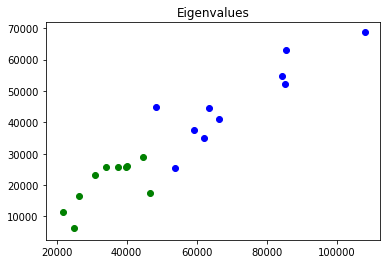

In [8]:
zeros_dec_1 = []
zeros_dec_2 = []

ones_dec_1 = []
ones_dec_2 = []

for i in range(len(zeros_im)):
    
    # Calcuate covariance matrix
    cov = calculateCovariance(zeros_im[i])
    # Calcuate eigenvalues and eigenvectors
    e_vals, e_vecs = np.linalg.eig(cov)

    # take the magnitude of the first and second largest eigenvalues
    zeros_dec_1.append(abs(e_vals[0]))
    zeros_dec_2.append(abs(e_vals[1]))

for i in range(len(ones_im)):
    cov = calculateCovariance(ones_im[i])
    e_vals, e_vecs = np.linalg.eig(cov)
    
    ones_dec_1.append(abs(e_vals[0]))
    ones_dec_2.append(abs(e_vals[1]))
    

plt.scatter(zeros_dec_1, zeros_dec_2, c='b')
plt.scatter(ones_dec_1, ones_dec_2, c='g')
plt.title("Eigenvalues")
plt.show()